In [131]:
import pandas as pd

# data = pd.read_csv("SHB_A-1987-01-02-2023-09-08.csv", sep=";", decimal=",", skiprows=1, encoding="utf-8")

# data.columns
column_order = ['Date', 'Bid', 'Ask', 'Opening price', 'High price', 'Low price', 'Closing price', 'Average price', 'Total volume', 'Turnover', 'Trades']
data = pd.read_csv("Raw_data/SHB_A-1987-01-02-2023-09-08.csv", sep=";", decimal=",", skiprows=1, usecols=column_order)

## TRANSFORM


,Closing price,Trades,Differenced Closing
Date,,,
1987-01-02,13.325,18,NaN
1987-01-05,13.325,20,0.000
1987-01-07,13.262,10,-0.063
1987-01-08,13.042,21,-0.220
1987-01-09,12.854,26,-0.188
...,...,...,...
2023-09-04,93.140,9517,1.800
2023-09-05,94.080,7826,0.940
2023-09-06,93.340,7429,-0.740


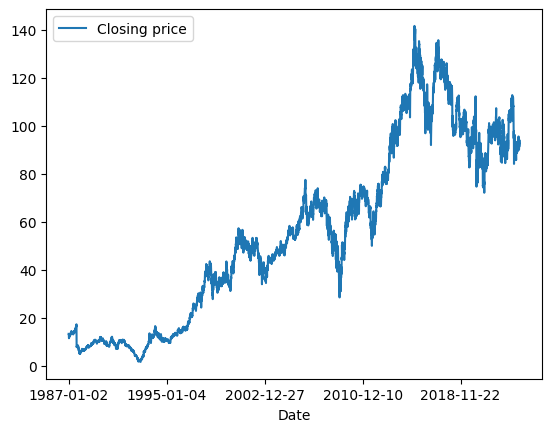

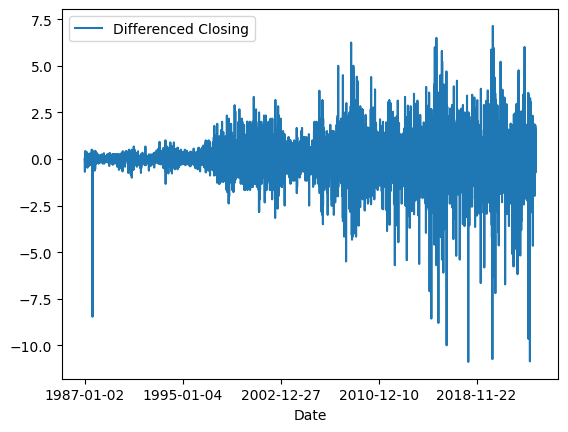

In [132]:

columns_to_drop = ["Bid", "Ask", "Opening price", "Average price"]
data = data.set_index("Date").drop(columns=columns_to_drop)

data = data.dropna(axis=1)

data = data[::-1] # Reverse dataset order

data.plot.line(y="Closing price")

data["Differenced Closing"] = data["Closing price"].diff()
    
data.plot.line(y="Differenced Closing")
data

In [133]:
PRED_HORIZON = 1 # 10
CHANGE_HORIZON = 10 # 20
FACTOR = 0.00 # Profit to define target

data["N_day_change"] = data["Closing price"] - data["Closing price"].shift(CHANGE_HORIZON)

data["Target"] = (data["Closing price"].shift(-PRED_HORIZON) > data["Closing price"] * (1 + FACTOR)).astype(int)

data = data.dropna()

data["Target"].value_counts()

0    4921
1    4274
Name: Target, dtype: int64

## Predict function

In [134]:
def predict(X_train, y_train, X_test, model, threshold):
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_test)[:,1]
    preds[preds >= threshold] = 1
    preds[preds < threshold] = 0

    return preds


## Print score function

In [135]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def print_acc(pred, y_test, model, cross_score): 
    # Evaluate the model's performance
    accuracy = accuracy_score(y_test, pred)
    confusion = confusion_matrix(y_test, pred)
    classification_report_str = classification_report(y_test, pred)

    print(f'Accuracy: {accuracy:.2f}')
    print('Confusion Matrix:\n', confusion)
    print('Classification Report:\n', classification_report_str)
    print('Cross Accuracy: %.3f (%.3f)' % (np.mean(cross_score), np.std(cross_score)))

    # Calculate the AUC (Area Under the ROC Curve)
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve Stationary')
    plt.legend(loc='lower right')
    plt.show()

Accuracy: 0.50
Confusion Matrix:
 [[913   6]
 [911   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.99      0.67       919
           1       0.60      0.01      0.02       920

    accuracy                           0.50      1839
   macro avg       0.55      0.50      0.34      1839
weighted avg       0.55      0.50      0.34      1839

Cross Accuracy: 0.504 (0.030)


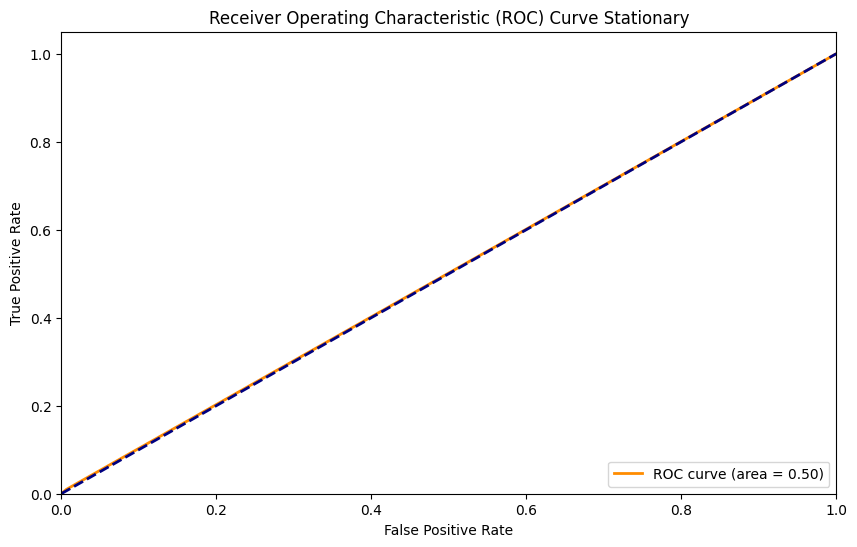

In [136]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

TRAIN_RATIO = 0.8
split_ix = int(len(data) * TRAIN_RATIO)

# Split the data into training and testing sets
x = data[["Differenced Closing", "N_day_change"]].values
y = data["Target"].values

X_train, X_test = x[:split_ix], x[split_ix:]
y_train, y_test = y[:split_ix], y[split_ix:]

model = LogisticRegression(random_state=1, C=0.5, class_weight='balanced')

# Cross validation
neg_cross_score = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
cross_score = - neg_cross_score

y_pred = predict(X_train=X_train, y_train=y_train, X_test=X_test, model=model, threshold=0.6)

print_acc(pred=y_pred, y_test=y_test, model=model, cross_score=cross_score)
